# Text Classification - Solution


In this notebook you will implement a binary classifier of Covid-19 related Tweets. 

In [1]:
# initial imports
import pandas as pd
import spacy
spacy.prefer_gpu()
# imports for text processing
from spacy.tokenizer import _get_regex_pattern
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [3]:
import kaggle
# If it doesn't work: 
# 1) Log into Kaggle -> Account -> Create New API Token (downloads kaggle.json)
# 2) (mac only) Press Cmd+Shift+. (period) and place kaggle.json in there 
# https://www.kaggle.com/docs/api
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
# Warning about readable file can be ignored

In [4]:
# Download Tweets from kaggle api (only once)
api.dataset_download_file('yasserh/twitter-tweets-sentiment-dataset', file_name='Tweets.csv')

True

In [5]:
# extract dataset from zip file
import zipfile
with zipfile.ZipFile('Tweets.csv.zip', 'r') as zipref:
    zipref.extractall()

In [6]:
# Read from downloaded csv
original_tweets = pd.read_csv("Tweets.csv")
original_tweets.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
# All possible sentiment values
original_tweets.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [8]:
# Count number of sentiment samples in dataset
original_tweets.sentiment.value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [9]:
original_tweets['text'] = original_tweets.text.astype(str)
original_tweets.loc[:, 'sentiment'] = original_tweets.sentiment.map(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)

In [10]:
# Text processing including:

import re 
import string 
import nltk
from tqdm import tqdm

# Preparing list of stop words and punctuations used for text processing
# (Quelle: SW7 Übung TextClassification)
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Function to remove URLs (Quelle: SW7 Übung TextClassification)
def remove_urls(text):
    text = re.sub(r"\S*https?:\S*", "", text, flags=re.MULTILINE)
    return text

# Function to remove hashtags (Quelle: SW7 Übung TextClassification)
def remove_hashtags(text):
    text = re.sub(r"#\w+|\w+-\w+", "", text, flags=re.MULTILINE)
    return text

# (Quelle: SW7 Übung TextClassification)
# Load English tokenizer, tagger, parser, NER and word vectors
nlp =  spacy.load("en_core_web_sm")
# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add your patterns (here: hashtags and in-word hyphens)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"
# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

# Remove emojis and non-unicode
# (Quelle: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)
def remove_emoji_or_non_unicodes(text):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Creating tokenizer function (Quelle: SW7 Übung TextClassification aber erweitert mit emoji&non-unicode funktion)
def spacy_tokenizer(sentence):
    
    # emoji und nicht unicode entfernen
    sentence = remove_emoji_or_non_unicodes(sentence)
    
    # Creating our token object, which is used to create documents with linguistic annotations.
    newtokens = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    newtokens = [word.lemma_.lower().strip() if (word.pos_ != "PRON") & (word.pos_ != "PROPN") else word.lemma_.strip() for word in newtokens ]
    
    # Removing stop words
    newtokens = [ word for word in newtokens if word not in stop_words and word not in punctuations ]
    
    # Remove links
    newtokens = [remove_urls(word) for word in newtokens]
    
    # Remove hashtags
    newtokens = [remove_hashtags(word) for word in newtokens]
    
    # return preprocessed list of tokens
    return newtokens

In [11]:
# Vorzeige Beispiel 2 mit emoji
print('Tweet text:')
print(original_tweets.text[527])
print('\nTokanized:')
spacy_tokenizer(original_tweets.text.values[527])

Tweet text:
i am living in ignorance  :@

Tokanized:


['I', 'live', 'ignorance']

In [12]:
# Train test split
from sklearn.model_selection import train_test_split

# Split the train, test, validation set
train_tweets, test_tweets = train_test_split(original_tweets, test_size = 0.2)

train_tweets.shape, test_tweets.shape

((21984, 4), (5497, 4))

In [13]:
# Label Encoder for classes in sentiment (Quelle: SW7 Übung TextClassification)
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_tweets.encoded_sentiment = encoder.fit_transform(train_tweets.sentiment)

encoder = LabelEncoder()
test_tweets.encoded_sentiment = encoder.fit_transform(test_tweets.sentiment)

/var/folders/ms/bdscwb3x6rz1b34v63g367q00000gn/T/ipykernel_93247/2885931097.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  train_tweets.encoded_sentiment = encoder.fit_transform(train_tweets.sentiment)
/var/folders/ms/bdscwb3x6rz1b34v63g367q00000gn/T/ipykernel_93247/2885931097.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test_tweets.encoded_sentiment = encoder.fit_transform(test_tweets.sentiment)


In [14]:
X_train = train_tweets.text
X_test = test_tweets.text
y_train = train_tweets.sentiment.values
y_test = test_tweets.sentiment.values

In [15]:
import tensorflow as tf
from tensorflow import keras as keras

In [16]:
# https://notebooks.githubusercontent.com/view/ipynb?color_mode=auto&commit=c57f070a31d60dccdbab295b3bbd8904b8fd33f9&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f676973742f6675726b616e6f7a6261792f33363931613630386131393264326437336437363333383737613437633739372f7261772f633537663037306133316436306463636462616232393562336262643839303462386664333366392f696d6264636c617373696669636174696f6e2d6f6e6c796576616c756174652e6970796e62&logged_in=false&nwo=furkanozbay%2F3691a608a192d2d73d7633877a47c797&path=imbdclassification-onlyevaluate.ipynb&repository_id=110980065&repository_type=Gist
# "maximum number of words in your vocabulary" -> word vectors
max_features = 20000
# Length of the output sequences (in number of timesteps)
sequence_length = 500

dataset=tf.data.Dataset.from_tensor_slices((X_train.values,y_train)).shuffle(100).batch(64).prefetch(tf.data.AUTOTUNE)

encoder = keras.layers.TextVectorization(max_tokens=max_features,output_mode="int",output_sequence_length=sequence_length)
encoder.adapt(dataset.map(lambda text, label: text))

2022-06-09 19:29:21.408255: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91
# https://www.kaggle.com/code/sounishnath003/twitter-sentiment
from keras import regularizers

inputs = keras.Input(shape=(1,), dtype=tf.string)
x = encoder(inputs)
x = keras.layers.Embedding(max_features, 64) (x)
x = keras.layers.Dropout(0.5) (x)
x = keras.layers.Conv1D(128, 7, activation='relu') (x)
x = keras.layers.Conv1D(128, 7, activation='relu') (x)
x = keras.layers.MaxPooling1D(5) (x) 
x = keras.layers.Conv1D(64, 7, activation='relu') (x)
x = keras.layers.Dense(64, activation='relu', kernel_initializer = tf.keras.initializers.he_normal) (x)
x = keras.layers.GlobalMaxPooling1D() (x)
x = keras.layers.Dropout(0.5) (x)
x = keras.layers.Dense(3,activation='softmax') (x)

predictions = keras.layers.Dense(3, activation="softmax", name="predictions")(x)
model = keras.Model(inputs, predictions)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 500, 64)           1280000   
                                                                 
 dropout_4 (Dropout)         (None, 500, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 494, 128)          57472     
                                                                 
 conv1d_5 (Conv1D)           (None, 488, 128)          114816    
                                                           

In [35]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))

Epoch 1/10
687/687 [==============================] - 93s 135ms/step - loss: 1.0022 - accuracy: 0.4714 - val_loss: 0.8769 - val_accuracy: 0.5829
Epoch 2/10
687/687 [==============================] - 93s 136ms/step - loss: 0.8166 - accuracy: 0.6462 - val_loss: 0.7792 - val_accuracy: 0.6884
Epoch 3/10
687/687 [==============================] - 92s 133ms/step - loss: 0.7022 - accuracy: 0.7322 - val_loss: 0.7672 - val_accuracy: 0.6938
Epoch 4/10
687/687 [==============================] - 91s 133ms/step - loss: 0.6281 - accuracy: 0.7708 - val_loss: 0.7578 - val_accuracy: 0.7004
Epoch 5/10
687/687 [==============================] - 92s 134ms/step - loss: 0.5722 - accuracy: 0.7997 - val_loss: 0.7572 - val_accuracy: 0.7115
Epoch 6/10
687/687 [==============================] - 94s 136ms/step - loss: 0.5217 - accuracy: 0.8256 - val_loss: 0.7666 - val_accuracy: 0.7137
Epoch 7/10
687/687 [==============================] - 93s 135ms/step - loss: 0.4865 - accuracy: 0.8391 - val_loss: 0.7755 - val_ac

In [37]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [39]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
from sklearn import metrics

prediction = model.predict(X_test).argmax(axis=1)
print('accuracy=', metrics.accuracy_score(y_test, prediction))
print('f1=', metrics.f1_score(y_test, prediction, average='macro'))
print('precision=', metrics.precision_score(y_test, prediction, average='macro'))

accuracy= 0.7080225577587775
f1= 0.7097401642081668
precision= 0.7198651861162544


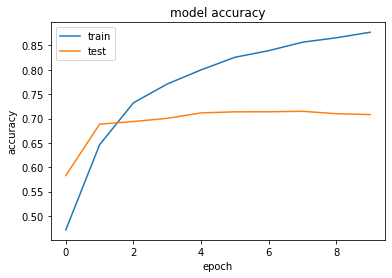

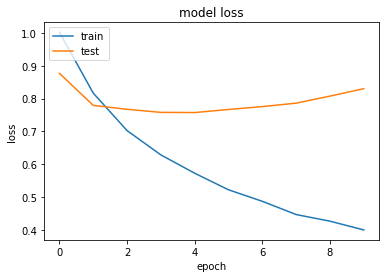

<Figure size 432x288 with 0 Axes>

In [40]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('plot/accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('plot/loss.png')

In [41]:
model.save("ADS_Gruppenarbeit/model")

2022-06-06 19:45:24.902729: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ADS_Gruppenarbeit/model/assets


In [217]:
# https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
# from sklearn.metrics import roc_curve
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(X_test, y_test, prediction)